In [1]:
import pandas as pd
import numpy as np
from math import factorial

df = pd.read_excel("data-pemodelan.xlsx")

df['datetime_started'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d')
                                        + ' ' + df['call_started'].astype(str))

df = df.sort_values(['date', 'datetime_started'])

df['interarrival'] = df.groupby('date')['datetime_started'].diff().dt.total_seconds()
interarrivals = df['interarrival'].dropna()

mean_interarrival = interarrivals.mean()
lam = 1 / mean_interarrival   # λ (per second)

mean_service = df['service_length'].mean()
mu = 1 / mean_service         # μ (per second)

c = 4

a = lam / mu
rho = lam / (c * mu)

sum_terms = sum((a**n) / factorial(n) for n in range(c))
last_term = (a**c) / (factorial(c) * (1 - rho))
P0 = 1 / (sum_terms + last_term)

Lq = ((a**c) * rho / (factorial(c) * (1 - rho)**2)) * P0
L = Lq + a
Wq = Lq / lam
W = Wq + 1/mu
P_wait = ((a**c) / (factorial(c) * (1 - rho))) * P0

print("=== HASIL PERHITUNGAN M/M/c ===")
print(f"Laju kedatangan λ (per hour)     : {lam*3600:.4f}")
print(f"Laju pelayanan μ (per hour)      : {mu*3600:.4f}")
print(f"Utilisasi ρ                       : {rho:.4f}")
print(f"P0 (sistem kosong)                : {P0:.4f}")
print(f"Lq (pelanggan dalam antrian)      : {Lq:.4f}")
print(f"L  (pelanggan dalam sistem)       : {L:.4f}")
print(f"Wq (waktu tunggu) - detik         : {Wq:.4f}")
print(f"W  (total waktu) - detik          : {W:.4f}")
print(f"P(wait) pelanggan harus menunggu  : {P_wait:.4f}")


=== HASIL PERHITUNGAN M/M/c ===
Laju kedatangan λ (per hour)     : 14.0664
Laju pelayanan μ (per hour)      : 11.8205
Utilisasi ρ                       : 0.2975
P0 (sistem kosong)                : 0.3032
Lq (pelanggan dalam antrian)      : 0.0153
L  (pelanggan dalam sistem)       : 1.2053
Wq (waktu tunggu) - detik         : 3.9090
W  (total waktu) - detik          : 308.4641
P(wait) pelanggan harus menunggu  : 0.0361


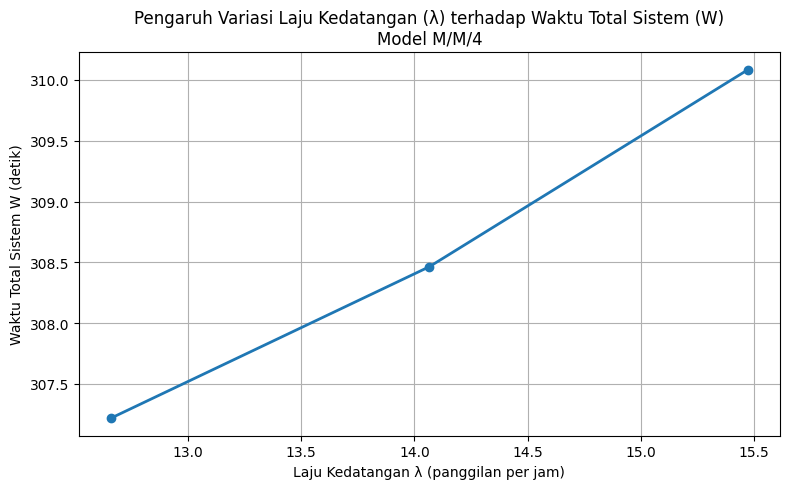


=== TABEL PENGARUH λ TERHADAP W (M/M/4) ===
λ = 12.66 per hour  -->  W = 307.2174 detik
λ = 14.07 per hour  -->  W = 308.4641 detik
λ = 15.47 per hour  -->  W = 310.0854 detik


In [2]:
import matplotlib.pyplot as plt

df = pd.read_excel("data-pemodelan.xlsx")

df['datetime_started'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d')
                                        + ' ' + df['call_started'].astype(str))

df = df.sort_values(['date', 'datetime_started'])

df['interarrival'] = df.groupby('date')['datetime_started'].diff().dt.total_seconds()
interarrivals = df['interarrival'].dropna()

mean_interarrival = interarrivals.mean()
lam_original = 1 / mean_interarrival   # λ dasar (per sec)

mean_service = df['service_length'].mean()
mu = 1 / mean_service                   # μ (per sec)

c = 4
lambda_values = np.array([
    lam_original * 0.90,   # -10%
    lam_original,          # normal
    lam_original * 1.10    # +10%
])

W_results = []

def compute_W(lam, mu, c):
    a = lam / mu
    rho = lam / (c * mu)

    sum_terms = sum((a**n) / factorial(n) for n in range(c))
    last_term = (a**c) / (factorial(c) * (1 - rho))
    P0 = 1 / (sum_terms + last_term)

    Lq = ((a**c) * rho / (factorial(c) * (1 - rho)**2)) * P0
    Wq = Lq / lam
    W = Wq + 1/mu
    return W

for lam in lambda_values:
    W_results.append(compute_W(lam, mu, c))

plt.figure(figsize=(8,5))
plt.plot(lambda_values * 3600, W_results, marker='o', linewidth=2)

plt.title("Pengaruh Variasi Laju Kedatangan (λ) terhadap Waktu Total Sistem (W)\nModel M/M/4")
plt.xlabel("Laju Kedatangan λ (panggilan per jam)")
plt.ylabel("Waktu Total Sistem W (detik)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== TABEL PENGARUH λ TERHADAP W (M/M/4) ===")
for lam, W in zip(lambda_values, W_results):
    print(f"λ = {lam*3600:.2f} per hour  -->  W = {W:.4f} detik")


In [3]:
import numpy as np

wait_length = df['wait_length'].dropna()

mean = np.mean(wait_length)
std = np.std(wait_length, ddof=1)
n = len(wait_length)

ci_lower = mean - 1.96 * std / np.sqrt(n)
ci_upper = mean + 1.96 * std / np.sqrt(n)

print(f"Mean: {mean:.3f} detik")
print(f"SD: {std:.3f} detik")
print(f"CI95%: [{ci_lower:.3f}, {ci_upper:.3f}] detik")

Mean: 3.149 detik
SD: 19.536 detik
CI95%: [0.865, 5.434] detik


In [4]:
lam0 = 0.00391
mu0  = 0.00328
c = 4

def mmc_metrics(lam, mu, c):
    a = lam / mu
    rho = lam / (c * mu)

    sum_terms = sum((a**n) / factorial(n) for n in range(c))
    last_term = (a**c) / (factorial(c) * (1 - rho))
    P0 = 1 / (sum_terms + last_term)

    Lq = ((a**c) * rho / (factorial(c) * (1 - rho)**2)) * P0
    Wq = Lq / lam
    Pwait = ((a**c) / (factorial(c) * (1 - rho))) * P0

    return rho, Wq, Pwait

factors = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

print("Sweep sensitivitas lambda (c=4, mu tetap)")
print("faktor | lambda | rho | Wq(detik) | P(wait)")
for f in factors:
    lam = f * lam0
    rho, Wq, Pwait = mmc_metrics(lam, mu0, c)
    print(f"{f:>4.1f} | {lam:.6f} | {rho:.3f} | {Wq:.3f} | {Pwait:.3f}")


Sweep sensitivitas lambda (c=4, mu tetap)
faktor | lambda | rho | Wq(detik) | P(wait)
 0.7 | 0.002737 | 0.209 | 1.067 | 0.011
 0.8 | 0.003128 | 0.238 | 1.743 | 0.017
 0.9 | 0.003519 | 0.268 | 2.682 | 0.026
 1.0 | 0.003910 | 0.298 | 3.938 | 0.036
 1.1 | 0.004301 | 0.328 | 5.571 | 0.049
 1.2 | 0.004692 | 0.358 | 7.649 | 0.064
 1.3 | 0.005083 | 0.387 | 10.248 | 0.082


In [24]:
df['datetime_started'] = pd.to_datetime(
    df['date'].dt.strftime('%Y-%m-%d') + ' ' + df['call_started'].astype(str),
    errors='coerce'
)

df = df.sort_values(['date', 'datetime_started'])

df['interarrival'] = df.groupby('date')['datetime_started'].diff().dt.total_seconds()
interarrivals = df['interarrival'].dropna()

mean_interarrival = interarrivals.mean()
lam = 1 / mean_interarrival

mean_service = df['service_length'].dropna().mean()
mu = 1 / mean_service

c = 4

a = lam / mu
rho = lam / (c * mu)

sum_terms = sum((a**n) / factorial(n) for n in range(c))
last_term = (a**c) / (factorial(c) * (1 - rho))
P0 = 1 / (sum_terms + last_term)

Lq = ((a**c) * rho / (factorial(c) * (1 - rho)**2)) * P0

Wq = Lq / lam
W  = Wq + (1 / mu)

Wq_empiris = df['wait_length'].dropna().mean()
W_empiris  = Wq_empiris + (1 / mu)

service_standard = 10
meets_standard = (df['wait_length'] <= service_standard).mean()

comparison_table = pd.DataFrame({
    'Ukuran': ['Wq (detik)', 'W (detik)', 'Meets_standard'],
    'Teoritis': [round(Wq, 2), round(W, 2), '-'],
    'Empiris': [round(Wq_empiris, 3), round(W_empiris, 2), round(meets_standard, 3)]
})

print("=== PERBANDINGAN HASIL TEORITIS DAN EMPIRIS (SATUAN DETIK) ===")
print(comparison_table)

=== PERBANDINGAN HASIL TEORITIS DAN EMPIRIS (SATUAN DETIK) ===
           Ukuran Teoritis  Empiris
0      Wq (detik)     3.91    3.149
1       W (detik)   308.46  307.700
2  Meets_standard        -    0.968


In [28]:
lambda_values = [lam * 0.90, lam, lam * 1.10]

def mmc_metrics(lam_val, mu, c):
    rho = lam_val / (c * mu)

    if rho >= 1:
        return rho, float('inf'), float('inf')

    a = lam_val / mu
    sum_terms = sum((a**n) / factorial(n) for n in range(c))
    last_term = (a**c) / (factorial(c) * (1 - rho))
    P0 = 1 / (sum_terms + last_term)

    Lq = ((a**c) * rho / (factorial(c) * (1 - rho)**2)) * P0
    Wq = Lq / lam_val
    Pwait = last_term * P0

    return rho, Wq, Pwait

rows = []
for lam_val in lambda_values:
    rho, Wq, Pwait = mmc_metrics(lam_val, mu, c)
    rows.append({
        'λ (panggilan/detik)': round(lam_val, 5),
        'ρ': round(rho, 3),
        'Wq (detik)': round(Wq, 2),
        'P(wait)': round(Pwait, 3)
    })

sens_lambda_table = pd.DataFrame(rows)

print("=== SENSITIVITAS TERHADAP LAJU KEDATANGAN (λ) ===")
print(sens_lambda_table)

=== SENSITIVITAS TERHADAP LAJU KEDATANGAN (λ) ===
   λ (panggilan/detik)      ρ  Wq (detik)  P(wait)
0              0.00352  0.268        2.66    0.026
1              0.00391  0.298        3.91    0.036
2              0.00430  0.327        5.53    0.049


In [30]:
c = 3

def mmc_metrics(lam, mu, c):
    rho = lam / (c * mu)
    if rho >= 1:
        return rho, float('inf'), float('inf')

    a = lam / mu
    sum_terms = sum((a**n) / factorial(n) for n in range(c))
    last_term = (a**c) / (factorial(c) * (1 - rho))
    P0 = 1 / (sum_terms + last_term)

    Lq = ((a**c) * rho / (factorial(c) * (1 - rho)**2)) * P0
    Wq = Lq / lam
    Pwait = last_term * P0

    return rho, Wq, Pwait

rho, Wq, Pwait = mmc_metrics(lam, mu, c)

hasil_mm3 = pd.DataFrame({
    'Parameter': ['ρ', 'Wq (detik)', 'P(wait)'],
    'Nilai (M/M/3)': [round(rho, 3), round(Wq, 2), round(Pwait, 2)]
})

print(hasil_mm3)

    Parameter  Nilai (M/M/3)
0           ρ          0.397
1  Wq (detik)         23.290
2     P(wait)          0.140
